In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from glob import glob 

import helpers 
from dtables import SingleGroupDtableGenerator
from na_handling import handle_na
from models import train_models

pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)


In [ ]:
# load to dataframe
INFILE = '/home/grace/work/SEER/data/SEER_2010_2020_RICH.clean.tsv'
table = helpers.load_seer_data(INFILE)
table = helpers.format_predictors(table)

In [ ]:
# subsetting
PREDICTOR = 'cancer_group_CAT:hist_group_CAT'
RESPONSE = 'brain_met_BOOL'

# subset to records with notna local_ln_met & distant_ln_met
print(table.shape)
table = table.dropna(subset=['local_ln_met_BOOL', 'distant_ln_met_BOOL'])
print(table.shape)

# subset cancer_group:hist_group identities to those with minimum counts
table[PREDICTOR] = table['cancer_group_CAT'] + ':' + table['hist_group_CAT']
valid = helpers.select_categorical_feature_values(table, predictor=PREDICTOR, response=RESPONSE, min_cases_response=100)
maintable = table[table[PREDICTOR].isin(valid)].copy()
print()
maintable.groupby(PREDICTOR)[RESPONSE].value_counts().unstack().fillna(0).astype(int)

In [ ]:
BUDGET = 100
predictors = [
    'age',
    'GRADE',
    'TSTAGE',
    'local_ln_met',
    'distant_ln_met',
]

feature_ignore = {
    'Lung and Bronchus:cystic, mucinous and serous neoplasms': ['GRADE'],
    'Pancreas:adenomas and adenocarcinomas': ['GRADE'],
    'Prostate:adenomas and adenocarcinomas': ['GRADE'],
    'Skin:nevi and melanomas': ['GRADE'],
}
feature_value_blacklist = {'GRADE': 0.0, 'TSTAGE': 0.0}


# identity = 'Lung and Bronchus:adenomas and adenocarcinomas'
for identity in sorted(list(maintable[PREDICTOR].unique())):
    df = maintable[maintable[PREDICTOR]==identity]
    if identity in feature_ignore:
        featpreds = [x for x in predictors if x not in feature_ignore[identity]]
    else:
        featpreds = predictors
    generator = SingleGroupDtableGenerator(df, featpreds, RESPONSE)
    dtable = generator.generate()
    dtable = handle_na(dtable, response=RESPONSE, verbose=True)
    for feat, banned_val in feature_value_blacklist.items():
        if feat in dtable.columns:
            dtable = dtable[dtable[feat]!=banned_val]

    print()
    print(identity)
    print(dtable[RESPONSE].value_counts())

    # init results dataframes
    dt_features_frame = pd.DataFrame()
    dt_metrics_frame = pd.DataFrame()
    lr_features_frame = pd.DataFrame()
    lr_metrics_frame = pd.DataFrame()

    for i in range(BUDGET):
        dtable_s = helpers.equalise_proportions(dtable, boolfield=RESPONSE)
        dtable_s[RESPONSE] = dtable_s[RESPONSE].map({True: 1, False: 0})
        dt_sframe, dt_mseries, lr_sframe, lr_mseries = train_models(dtable_s, RESPONSE)
        dt_features_frame[f"run{i}"] = dt_sframe['Importance']
        lr_features_frame[f"run{i}"] = lr_sframe['Coefficient']
        dt_metrics_frame[f"run{i}"] = dt_mseries
        lr_metrics_frame[f"run{i}"] = lr_mseries

    # odds ratios
    or_frame = lr_features_frame.apply(np.exp)
    alpha = 0.05
    or_summary = pd.DataFrame(index=or_frame.index)
    or_summary['mean'] = or_frame.mean(axis=1)
    or_summary['std'] = or_frame.std(axis=1)
    or_summary['count'] = or_frame.count(axis=1)
    or_summary['t_critical'] = or_summary.apply(lambda row: stats.t.ppf(1 - alpha/2, df=row['count'] - 1), axis=1)
    or_summary['margin_of_error'] = or_summary['t_critical'] * (or_summary['std'] / np.sqrt(or_summary['count']))
    or_summary['ci_lower'] = or_summary['mean'] - or_summary['margin_of_error']
    or_summary['ci_upper'] = or_summary['mean'] + or_summary['margin_of_error']
    cgroup_fmt = ''.join([x.capitalize() for x in identity.split(':')[0].split(' ')])
    hgroup_fmt = ''.join([x.capitalize() for x in identity.split(':')[1].split(' ')])
    outfile = f"/home/grace/work/SEER/outputs/figure4/{cgroup_fmt}_{hgroup_fmt}.tsv"
    or_summary.reset_index().to_csv(outfile, sep='\t', index=False, float_format='%.3f')


In [ ]:
# identity = 'Prostate:adenomas and adenocarcinomas'
identity = 'Lung and Bronchus:adenomas and adenocarcinomas'
df = maintable[maintable[PREDICTOR]==identity]
print(df[RESPONSE].value_counts())
print(df['local_ln_met_BOOL'].value_counts())


In [ ]:
lung_prob = 9271 / (9271+58639)  # 0.136
lung_localln_prob = 32955 / (32955+35169)
lung_localln_or = 3.387

prostate_prob = 121 / (121+207168)
prostate_localln_prob = 12997 / (12997+194441)
prostate_localln_or = 7.151

# if prostate had the same rate of ln_local as lung, would prostate risk be similar to lung risk?
factor = lung_localln_prob/prostate_localln_prob
expected = prostate_prob * factor * prostate_localln_or
relrisk_lung = lung_prob/expected
print(expected)
print(relrisk_lung) 



# expected = lung_localln_odds

# lung_localln_adjOR = (9271 * (prostate_localln_odds/lung_localln_odds) * lung_localln_or) / 58639
# prostate_localln_adjOR = (121 * (lung_localln_odds/prostate_localln_odds) * prostate_localln_or) / 207168


# print(lung_localln_adjOR)
# print(prostate_localln_adjOR)

# prob = baseline_prob

# prostate_risk = 121 / (121+207168)
# prostate_mean_localln = 12997 / (12997+194441)

# lung_localln_rr = Odds Ratio / (1 - Baseline Risk + (Baseline Risk * Odds Ratio))



In [ ]:
# infiles = glob('/home/grace/work/SEER/outputs/figure4/*.tsv')

# for filepath in infiles:
#     df = 


In [ ]:

# for field in dtable.columns:
#     if field == 'age':
#         continue 
#     print()
#     print(dtable[field].value_counts(dropna=False))


# def calc_relrisk(odds_ratio: float, baseline_risk: float) -> float:
#     return odds_ratio / (1 - baseline_risk + (baseline_risk * odds_ratio))

# n_pos = df[df[RESPONSE]==True].shape[0]
# baseline_risk = n_pos / df.shape[0]

# # relative risk
# rr_frame = or_frame.apply(calc_relrisk, baseline_risk=baseline_risk)
# alpha = 0.05
# rr_summary = pd.DataFrame(index=rr_frame.index)
# rr_summary['mean'] = rr_frame.mean(axis=1)
# rr_summary['std'] = rr_frame.std(axis=1)
# rr_summary['count'] = rr_frame.count(axis=1)
# rr_summary['t_critical'] = rr_summary.apply(lambda row: stats.t.ppf(1 - alpha/2, df=row['count'] - 1), axis=1)
# rr_summary['margin_of_error'] = rr_summary['t_critical'] * (rr_summary['std'] / np.sqrt(rr_summary['count']))
# rr_summary['ci_lower'] = rr_summary['mean'] - rr_summary['margin_of_error']
# rr_summary['ci_upper'] = rr_summary['mean'] + rr_summary['margin_of_error']
# print()
# print(rr_frame)
# print()
# print(rr_summary)

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# # Sample data for demonstration
# # In a real scenario, these would come from your statistical analysis (e.g., logistic regression)
# data = {
#     'Variable': ['Exposure A', 'Exposure B', 'Exposure C'],
#     'Odds Ratio': [1.5, 0.8, 2.3],
#     'Lower CI': [1.1, 0.6, 1.8],
#     'Upper CI': [2.0, 1.1, 3.0]
# }
# df = pd.DataFrame(data)

# # Set up the plot style
# sns.set_style("whitegrid")
# fig, ax = plt.subplots(figsize=(8, 6))

# # Plot the odds ratios and confidence intervals
# for index, row in df.iterrows():
#     # Plot the confidence interval as a horizontal line
#     ax.plot([row['Lower CI'], row['Upper CI']], [index, index], color='grey', linewidth=2)
#     # Plot the odds ratio as a marker
#     ax.plot(row['Odds Ratio'], index, 'o', color='blue', markersize=8)

# # Add a vertical line at Odds Ratio = 1 (no effect)
# ax.axvline(x=1, color='black', linestyle='--', linewidth=1)

# # Customize the plot
# ax.set_yticks(range(len(df)))
# ax.set_yticklabels(df['Variable'])
# ax.set_xlabel("Odds Ratio")
# ax.set_ylabel("Variable")
# ax.set_title("Forest Plot of Odds Ratios")
# ax.set_xscale('log') # Use a log scale for better visualization of skewed ORs

# plt.tight_layout()
# plt.show()

          Feature   mean    std  count  t_critical  margin_of_error  ci_lower  ci_upper            Primary
1          TSTAGE  1.615  0.067    100       1.984            0.013     1.602     1.628  Lung and Bronchus
2             age  0.778  0.027    100       1.984            0.005     0.773     0.783  Lung and Bronchus
3  distant_ln_met  3.182  0.658    100       1.984            0.131     3.052     3.313  Lung and Bronchus
4    local_ln_met  3.387  0.212    100       1.984            0.042     3.345     3.429  Lung and Bronchus
5          TSTAGE  1.648  0.223    100       1.984            0.044     1.603     1.692           Prostate
6             age  1.553  0.190    100       1.984            0.038     1.515     1.591           Prostate
7  distant_ln_met  3.261  0.747    100       1.984            0.148     3.112     3.409           Prostate
8    local_ln_met  7.151  2.516    100       1.984            0.499     6.652     7.650           Prostate


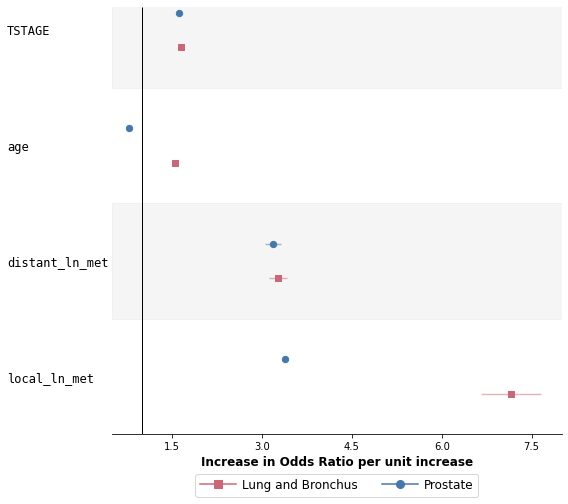

In [63]:
import forestplot as fp
import matplotlib.pyplot as plt 

INFILE_OR_STATS_LUNG_ADENOCARCINOMA = '/home/grace/work/SEER/outputs/figure4/LungAndBronchus_AdenomasAndAdenocarcinomas.tsv'
INFILE_OR_STATS_PROSTATE_ADENOCARCINOMA = '/home/grace/work/SEER/outputs/figure4/Prostate_AdenomasAndAdenocarcinomas.tsv'

df1 = pd.read_csv(INFILE_OR_STATS_LUNG_ADENOCARCINOMA, sep='\t', header=0)
df2 = pd.read_csv(INFILE_OR_STATS_PROSTATE_ADENOCARCINOMA, sep='\t', header=0)
df1['Primary'] = 'Lung and Bronchus'
df2['Primary'] = 'Prostate'
table = pd.concat([df1, df2], ignore_index=True)
table = table[table['Feature']!='GRADE']
print(table) 

std_opts = dict(
    dataframe = table,
    estimate = "mean",
    ll  ="ci_lower", 
    hl = "ci_upper",
    varlabel = "Feature",
    model_col = "Primary",
    return_df=True,
    ylabel="Confidence interval",  # y-label title
    xlabel="Increase in Odds Ratio per unit increase",  # x-label title
    modellabels=["Lung and Bronchus", "Prostate"],
    mcolor=["#CC6677", "#4477AA"],
)

# Vanilla
_df, ax = fp.mforestplot(**std_opts, color_alt_rows=True, figsize=(8,7))
ax.set_xlim(0.5, 8)
ax.vlines(x=1, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='black', linewidth=1)
plt.tight_layout()
plt.show()
plt.close()

# fp.forestplot(
#     table,  # the dataframe with results data
#     estimate="mean", 
#     ll="ci_lower", 
#     hl="ci_upper",  
#     varlabel="Feature",  # column containing variable label
#     model_col="Primary",
#     # xticks=[0.5, 1, 1.5, 2, 2.5, 3, 3.5],
#     ax=ax
# )
# # ax.set_xlim(0.5, 3.5)
